In [ ]:
# 1. Mounting Google Drive and copying dataset to local storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the dataset from Drive to local directory for faster access
!cp -r "/content/drive/MyDrive/VegetableImages" /content/vegetable_dataset

In [ ]:
# 2. Setting up directories and data augmentation
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Base directory for the dataset
base_path = "/content/vegetable_dataset"
train_dir = os.path.join(base_path, "train")
val_dir   = os.path.join(base_path, "validation")
test_dir  = os.path.join(base_path, "test")

In [ ]:
# Data augmentation for training dataset.
# (Note: augmentation is applied only on training images for robust learning)
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=40,      # Random rotations (in degrees)
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2, # Random vertical shifts
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flips
    fill_mode='nearest'     # Fill in missing pixels
)

In [ ]:
# For validation and test sets, we only need to rescale.
test_val_datagen = ImageDataGenerator(rescale=1./255)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32



In [ ]:
# Loading data from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 15090 images belonging to 15 classes.
Found 3020 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
# 3. Visualizing the data: Class distribution and sample images
import matplotlib.pyplot as plt


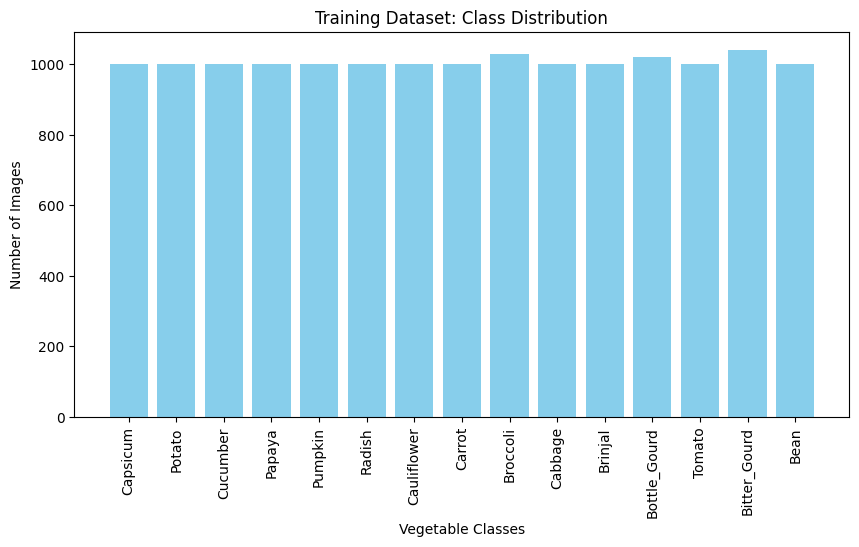

In [ ]:
# Plot class distribution in the training dataset
class_names = os.listdir(train_dir)
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names]

plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Vegetable Classes')
plt.ylabel('Number of Images')
plt.title('Training Dataset: Class Distribution')
plt.show()


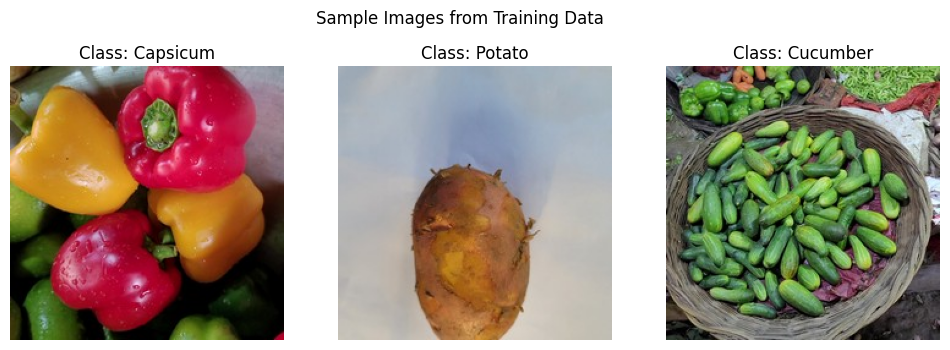

In [ ]:
# Display sample images from the first three classes
sample_images = []
for cls in class_names[:3]:
    image_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = plt.imread(image_path)
    sample_images.append(img)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i])
    ax.axis('off')
    ax.set_title(f"Class: {class_names[i]}")
plt.suptitle("Sample Images from Training Data")
plt.show()



In [ ]:
# 4. Building the Model using Transfer Learning (MobileNetV2)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2

In [ ]:
# Load pre-trained MobileNetV2 model + higher level layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Create a new model on top of it
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),      # Reduces each feature map to a single value
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')  # Output layer with softmax activation
])  xz

In [ ]:
# Compile the model with Adam optimizer and a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 5. Train the Model with Callbacks for Early Stopping and Best Model Saving
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_vegetable_classifier_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [ ]:
EPOCHS = 10

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.4390 - loss: 1.8267
Epoch 1: val_accuracy improved from -inf to 0.97219, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 219s 442ms/step - accuracy: 0.4394 - loss: 1.8253 - val_accuracy: 0.9722 - val_loss: 0.2056
Epoch 2/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9020 - loss: 0.3734
Epoch 2: val_accuracy improved from 0.97219 to 0.98113, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 196s 414ms/step - accuracy: 0.9020 - loss: 0.3733 - val_accuracy: 0.9811 - val_loss: 0.0928
Epoch 3/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9415 - loss: 0.2282
Epoch 3: val_accuracy improved from 0.98113 to 0.98609, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 204s 431ms/step - accuracy: 0.9415 - loss: 0.2281 - val_accuracy: 0.9861 - val_loss: 0.0590
Epoch 4/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9551 - loss: 0.1604
Epoch 4: val_accuracy improved from 0.98609 to 0.99139, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 199s 421ms/step - accuracy: 0.9551 - loss: 0.1604 - val_accuracy: 0.9914 - val_loss: 0.0404
Epoch 5/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9704 - loss: 0.1178
Epoch 5: val_accuracy improved from 0.99139 to 0.99272, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 203s 431ms/step - accuracy: 0.9704 - loss: 0.1178 - val_accuracy: 0.9927 - val_loss: 0.0330
Epoch 6/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9743 - loss: 0.1030
Epoch 6: val_accuracy improved from 0.99272 to 0.99503, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 203s 431ms/step - accuracy: 0.9743 - loss: 0.1030 - val_accuracy: 0.9950 - val_loss: 0.0249
Epoch 7/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9765 - loss: 0.0898
Epoch 7: val_accuracy did not improve from 0.99503
472/472 ━━━━━━━━━━━━━━━━━━━━ 201s 426ms/step - accuracy: 0.9765 - loss: 0.0898 - val_accuracy: 0.9950 - val_loss: 0.0222
Epoch 8/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9781 - loss: 0.0811
Epoch 8: val_accuracy improved from 0.99503 to 0.99636, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 199s 421ms/step - accuracy: 0.9781 - loss: 0.0811 - val_accuracy: 0.9964 - val_loss: 0.0182
Epoch 9/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9807 - loss: 0.0709
Epoch 9: val_accuracy improved from 0.99636 to 0.99702, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 195s 414ms/step - accuracy: 0.9807 - loss: 0.0709 - val_accuracy: 0.9970 - val_loss: 0.0151
Epoch 10/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9817 - loss: 0.0648
Epoch 10: val_accuracy improved from 0.99702 to 0.99768, saving model to best_vegetable_classifier_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 202s 427ms/step - accuracy: 0.9817 - loss: 0.0648 - val_accuracy: 0.9977 - val_loss: 0.0133
Restoring model weights from the end of the best epoch: 10.


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9969 - loss: 0.0129
Test Accuracy: 1.00


In [ ]:
# Save the final model
model.save("vegetable_classifier_model_final2.h5")

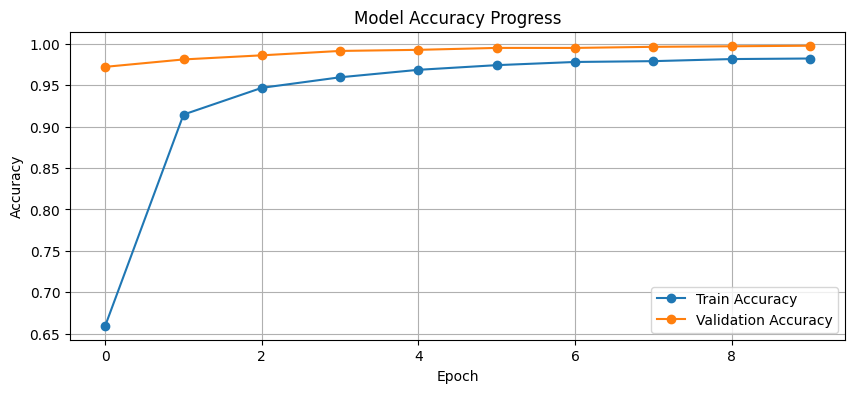

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

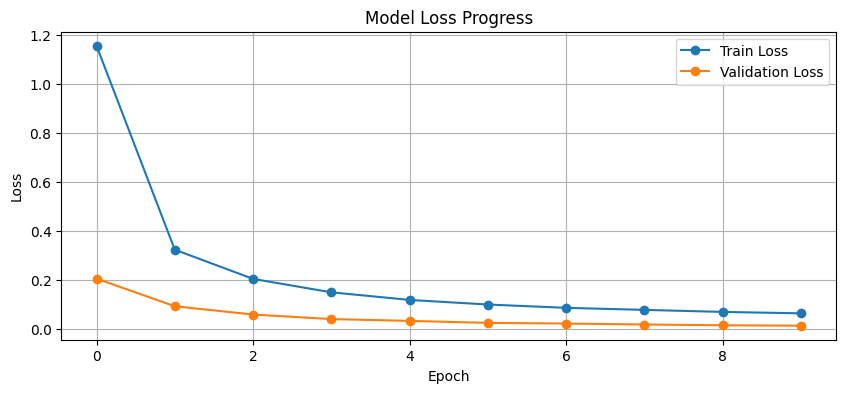

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# 6. Testing on a single image from the test set and visualizing prediction
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:

# Replace with an actual file path from test folder (example for class "Bean")
img_path = "/content/vegetable_dataset/test/Bean/0001.jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

In [ ]:

# Predict the image class
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Predicted Class: Bean


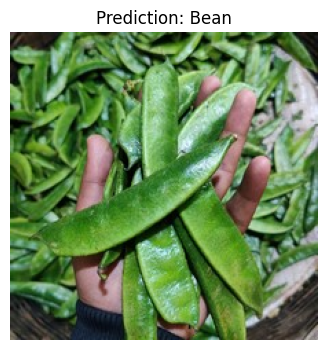

In [ ]:

# Get class labels (from training data)
class_labels = list(train_data.class_indices.keys())
print("Predicted Class:", class_labels[predicted_class])

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"Prediction: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()


🎯 Sample Predictions from the Test Set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


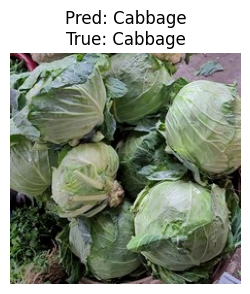

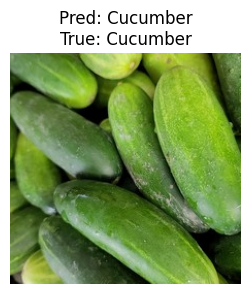

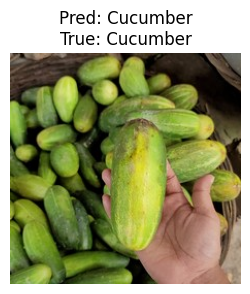

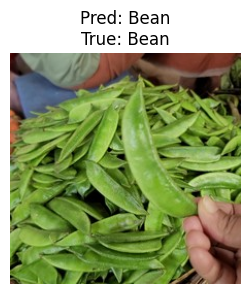

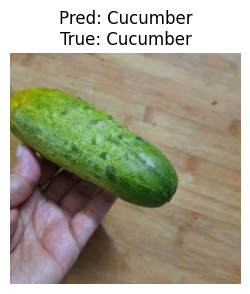

In [ ]:
# 7. Visualizing multiple sample predictions along with true labels
def test_sample_images(num_samples=5):
    print("\n🎯 Sample Predictions from the Test Set:")
    sample_batch = next(test_data)
    sample_images_batch, sample_labels_batch = sample_batch[0][:num_samples], sample_batch[1][:num_samples]
    predictions_batch = model.predict(sample_images_batch)

    for i in range(num_samples):
        plt.figure(figsize=(3,3))
        plt.imshow(sample_images_batch[i])
        plt.axis('off')
        pred_label = class_labels[np.argmax(predictions_batch[i])]
        true_label = class_labels[np.argmax(sample_labels_batch[i])]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.show()

test_sample_images(num_samples=5)

In [ ]:
# 8. Additional Visualization: Confusion Matrix and Classification Report
import itertools
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Generate predictions for entire test set for evaluation
test_data.reset()  # Ensure the generator is at the start
predictions = model.predict(test_data, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[12 11 11 17 14 15 12 13 18 15 11  8 13 15 15]
 [ 7 15 18 15 11 10 13 16 12 12 19  9 19 14 10]
 [14 13 15 11  9  9 17 13 12 14 13 20 12 16 12]
 [11 16 11 18 15 14 14 17 10 12 11 11 15 11 14]
 [15  6 19 16  7 13 11 15 13 17 13 13 15 15 12]
 [12 16  6 10 18 12 15 15 18 12 14 19 12  8 13]
 [15  8  9 13 18 15 12 12 14 15 11 14 19 15 10]
 [20 12 12  9  9 11 13 10 13 16 10 21 11 15 18]
 [19 16 14 15 12 16 11 11 12 12 11 18  8 10 15]
 [19 15  9 17 18  5 21 13 10 14  9 16  8 15 11]
 [16 18 12 17 14 11 15 11 12 12  9  6 15 13 19]
 [ 8 18 18 13 10 20 15  9 13  7 17 11  8 16 17]
 [12 13 17 12 13 19  4 14 18 17 13 10 16 11 11]
 [12  6 13 11 16 16 14 17 11  7 15 14 17 19 12]
 [ 9 15 15  9 14 13 15 14 19 17 21 10 11  7 11]]


([<matplotlib.axis.YTick at 0x7861123de010>,
 [Text(0, 0, 'Bean'),
  Text(0, 1, 'Bitter_Gourd'),
  Text(0, 2, 'Bottle_Gourd'),
  Text(0, 3, 'Brinjal'),
  Text(0, 4, 'Broccoli'),
  Text(0, 5, 'Cabbage'),
  Text(0, 6, 'Capsicum'),
  Text(0, 7, 'Carrot'),
  Text(0, 8, 'Cauliflower'),
  Text(0, 9, 'Cucumber'),
  Text(0, 10, 'Papaya'),
  Text(0, 11, 'Potato'),
  Text(0, 12, 'Pumpkin'),
  Text(0, 13, 'Radish'),
  Text(0, 14, 'Tomato')])

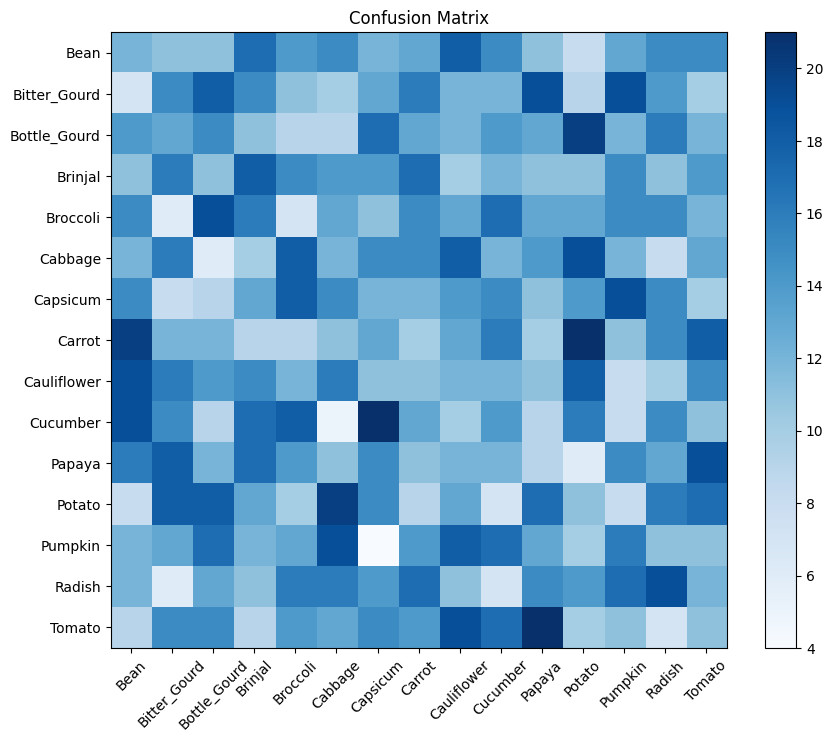

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)